# Read in data

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np

import sys

sys.path.append("../scripts")

from process_raw_hector_output import *
from condense_hector_output import *

In [2]:
input_path = "../data/postprocessed-hector/netcdfs/"
DAC_emissionsDriven = xr.open_dataset(input_path + "DAC_emissionsDriven_postprocessed.nc")
DOR_emissionsDriven = xr.open_dataset(input_path + "DOR_emissionsDriven_postprocessed.nc")
DOR_concentrationDriven = xr.open_dataset(input_path + "DOR_concentrationDriven_postprocessed.nc")
DOR_concentrationDriven_highWind = xr.open_dataset(
    input_path + "DOR_concentrationDriven_highWind_postprocessed.nc"
)
DOR_concentrationDriven_lowWind = xr.open_dataset(
    input_path + "DOR_concentrationDriven_lowWind_postprocessed.nc"
)

DAC_concentrationDriven = xr.open_dataset(input_path + "DAC_concentrationDriven_synthetic_data.nc")
emission_concentrationDriven = xr.open_dataset(
    input_path + "emission_concentrationDriven_synthetic_data.nc"
)

# Convert data into json with flat structure

In [3]:
datasets = [
    DAC_emissionsDriven,
    DOR_emissionsDriven,
    DAC_concentrationDriven,
    DOR_concentrationDriven,
    emission_concentrationDriven,
    DOR_concentrationDriven_highWind,
    DOR_concentrationDriven_lowWind,
]

perturbation_types = ["DAC", "DOR", "DAC", "DOR", "emission", "DOR", "DOR"]
carbon_cycle_feedbacks = ["on", "on", "off", "off", "off", "off", "off"]
wind_speed = ["default", "default", "default", "default", "default", "high", "low"]

In [4]:
df_list = []
for i, ds in enumerate(datasets):
    if carbon_cycle_feedbacks[i] == "off":
        var_to_use = "implied_delta_atmos_co2_GtCO2"
    elif carbon_cycle_feedbacks[i] == "on":
        var_to_use = "delta_atmos_co2_GtCO2"

    df = ds[var_to_use].to_dataframe(name="value")

    # Add labels
    df["perturbation_type"] = perturbation_types[i]
    df["carbon_cycle_feedback"] = carbon_cycle_feedbacks[i]
    df["wind_speed"] = wind_speed[i]
    df["variable_label"] = var_to_use
    df["years_after_deployment"] = ds["years_after_deployment"]
    df_list.append(df)

df_all = pd.concat(df_list)
df_all = df_all.reset_index()

In [5]:
df_all_coarsened_time = df_all[
    ((df_all.years_after_deployment <= 100) | (df_all.years_after_deployment % 100 == 0))
]
df_all_coarsened_time = df_all_coarsened_time[df_all_coarsened_time.years_after_deployment > -10]

In [6]:
df_output = df_all_coarsened_time

# Test flat dataset

In [7]:
# Parameters to select
carbon_cycle_feedback = "on"
time_horizon = 10

# Get the right time series using
tseries_to_use_DOR = df_output[
    (df_output.perturbation_type == "DOR")
    & (df_output.carbon_cycle_feedback == carbon_cycle_feedback)
    & (df_output.wind_speed == "default")
]
tseries_to_use_DAC = df_output[
    (df_output.perturbation_type == "DAC")
    & (df_output.carbon_cycle_feedback == carbon_cycle_feedback)
    & (df_output.wind_speed == "default")
]

(-10.0, 100.0)

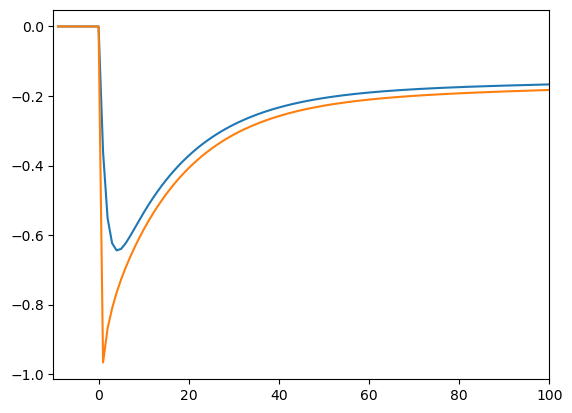

In [8]:
plt.plot(tseries_to_use_DOR.years_after_deployment, tseries_to_use_DOR.value)
plt.plot(tseries_to_use_DAC.years_after_deployment, tseries_to_use_DAC.value)
plt.xlim([-10, 100])

# Save json

In [9]:
json_directory = "../data/postprocessed-hector/jsons_for_article/"
df_output.to_json(json_directory + "DOR_vs_DAC_combined.json", orient="table")

# Old json generation

In [ ]:
for ds in ds_list:
    ds["delta_atmos_co2"] = (ds["atmos_co2"] - ds["atmos_co2"][0].values) * unitconv
    ds["delta_ocean_co2"] = (ds["ocean_c"] - ds["ocean_c"][0].values) * unitconv
    ds["fast_c"] = (
        ds["LL_ocean_c"]
        + ds["HL_ocean_c"]
        + ds["IO_ocean_c"]
        + ds["veg_c"]
        + ds["detritus_c"]
        + ds["soil_c"]
        + ds["atmos_co2"]
    )
    ds["slow_c"] = ds["DO_ocean_c"] + ds["earth_c"]
    ds["delta_fast_co2"] = (ds["fast_c"] - ds["fast_c"][0].values) * unitconv
    ds["delta_slow_co2"] = (ds["slow_c"] - ds["slow_c"][0].values) * unitconv

In [ ]:
ds_fromAtm_concDriven_postspinup["delta_atmos_co2_implied"] = (
    ds_fromAtm_concDriven_postspinup["delta_atmos_co2"] * 0
)
ds_fromAtm_concDriven_postspinup["delta_atmos_co2_implied"][2:] = -10

ds_fromOcn_concDriven_postspinup["delta_atmos_co2_implied"] = (
    -ds_fromOcn_concDriven_postspinup["delta_ocean_co2"]
    + ds_fromOcn_concDriven_postspinup["delta_ocean_co2"][1]
)
ds_fromOcn_concDriven_postspinup["delta_atmos_co2_implied"][0] = 0

In [ ]:
ds_fromAtm_concDriven_postspinup["delta_fast_co2_implied"] = (
    ds_fromAtm_concDriven_postspinup["delta_atmos_co2"] * 0
)
ds_fromAtm_concDriven_postspinup["delta_fast_co2_implied"][2:] = -10

ds_fromOcn_concDriven_postspinup[
    "delta_fast_co2_implied"
] = -ds_fromOcn_concDriven_postspinup.delta_slow_co2

### Make json with processed data

In [ ]:
datasets = [
    ds_fromOcn_emisDriven_postspinup,
    ds_fromOcn_emisDriven_postspinup,
    ds_fromOcn_concDriven_postspinup,
    ds_fromOcn_concDriven_postspinup,
    ds_fromAtm_emisDriven_postspinup,
    ds_fromAtm_emisDriven_postspinup,
    ds_fromAtm_concDriven_postspinup,
    ds_fromAtm_concDriven_postspinup,
]

CDR_types = ["DOR", "DOR", "DOR", "DOR", "DAC", "DAC", "DAC", "DAC"]
carbon_cycle_feedbacks = ["on", "on", "off", "off", "on", "on", "off", "off"]
ds_vars = [
    "delta_atmos_co2",
    "delta_fast_co2",
    "delta_atmos_co2_implied",
    "delta_fast_co2_implied",
    "delta_atmos_co2",
    "delta_fast_co2",
    "delta_atmos_co2_implied",
    "delta_fast_co2_implied",
]
frames_of_reference = [
    "atmos_co2",
    "fast_c",
    "atmos_co2",
    "fast_c",
    "atmos_co2",
    "fast_c",
    "atmos_co2",
    "fast_c",
]
y_axis_labels = [
    "change_in_atmospheric_carbon",
    "change_in_fast_carbon_pool",
    "calculated_change_in_atmospheric_carbon",
    "calculated_change_in_fast_carbon_pool",
    "change_in_atmospheric_carbon",
    "change_in_fast_carbon_pool",
    "calculated_change_in_atmospheric_carbon",
    "calculated_change_in_fast_carbon_pool",
]

years_after_deployment = np.arange(-2, 1702 - 3)
df_list = []
for i, ds in enumerate(datasets):
    var_to_use = ds_vars[i]
    df = ds[var_to_use].to_dataframe(name="value")
    df["CDR_type"] = CDR_types[i]
    df["carbon_cycle_feedback"] = carbon_cycle_feedbacks[i]
    df["y_axis_label"] = y_axis_labels[i]
    df["frame_of_reference"] = frames_of_reference[i]
    df["years_after_deployment"] = years_after_deployment
    df_list.append(df)

df_all = pd.concat(df_list)
df_all = df_all.reset_index()

In [ ]:
df_all_first100years = df_all[df_all.years_after_deployment <= 100]

In [ ]:
df_all_first100years.to_json("DOR_vs_DAC_all_timeseries.json", orient="table")

### Example calculation of bar graph numbers

In [ ]:
# Parameters to select
carbon_cycle_feedback = "on"
frame_of_reference = "atmos_co2"
time_horizon = 10
absolute_vs_relative = "absolute_drawdown"  # options: 'absolute_drawdown','normalize_to_DAC'

# Get the right time series using
tseries_to_use_DOR = df_all[
    (df_all.CDR_type == "DOR")
    & (df_all.carbon_cycle_feedback == carbon_cycle_feedback)
    & (df_all.frame_of_reference == frame_of_reference)
]
tseries_to_use_DAC = df_all[
    (df_all.CDR_type == "DAC")
    & (df_all.carbon_cycle_feedback == carbon_cycle_feedback)
    & (df_all.frame_of_reference == frame_of_reference)
]

# Get the DOR and DAC removals at that time series
removal_DOR = tseries_to_use_DOR[
    tseries_to_use_DOR.years_after_deployment == time_horizon
].value.item()
removal_DAC = tseries_to_use_DAC[
    tseries_to_use_DAC.years_after_deployment == time_horizon
].value.item()

# Choose whether to display the relative or absolute removal
if absolute_vs_relative == "normalize_to_DAC":
    DOR_to_display = (removal_DOR) / (removal_DAC)
elif absolute_vs_relative == "absolute_drawdown":  # doing elif here because may add a third option?
    DOR_to_display = -(removal_DOR) / 10

# DAC is always 1
DAC_to_display = 1